## Spam classifier web application

Spam messages are a major problem to individuals and businesses alike. These message clutter up our inboxes and storage spaces. We waste valuable time scanning through them at the risk of missing out on important messages.

In this project, I will build Naive Bayes and Neural Network (NN) classifiers to tell spam from non-spam (ham) messages. We will have a web application where we can paste new messages and check whether they are spam or not.

The deliverables for this projects are:
- 1. A Naive Bayes classifier
- 2. A NN classifier
- 3. A table of both classifier metrics
- 4. A web application to check whether new messages are spam or not

### 0. Download data and libraries

Uncomment to run:

In [1]:
# !pip install kaggle
# !pip install spacy
# !python -m spacy download en_core_web_sm

It's time to get our data. We shall be using the UCI Spam SMS data from Kaggle. We shall get the data with the Kaggle API. So provide  (in the empty strings) your kaggle `username`and kaggle `key`.


In [2]:
# download data
import os

os.environ['KAGGLE_USERNAME'] = ''   # put your Kaggle username
os.environ['KAGGLE_KEY'] = ''        # put your kaggle api key

!kaggle datasets download -d uciml/sms-spam-collection-dataset


  0%|          | 0.00/211k [00:00<?, ?B/s]
100%|##########| 211k/211k [00:00<00:00, 730kB/s]
100%|##########| 211k/211k [00:00<00:00, 728kB/s]


In [3]:
# Unzip the donwload file and save in the current working directory

import zipfile

with zipfile.ZipFile('sms-spam-collection-dataset.zip', 'r') as zip_file:
    zip_file.extractall('.')

### 1. Load and preprocess data

In [4]:
# Load data as pandas dataframe

import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(
    'spam.csv', encoding="iso-8859-1", 
    usecols=[0, 1], names=['target', 'sms'], header=0
)

In [5]:
# Split data into test and train sets

X_train, X_test, y_train, y_test = train_test_split(
    df['sms'], df['target'], 
    test_size=0.3, random_state=0
)

print('Train set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

Train set shape: (3900,) (3900,)
Test set shape: (1672,) (1672,)


In [6]:
import spacy
import string

nlp = spacy.load('en_core_web_sm')

def preprocessor(text):
    """
    Performs element-wise operation on a dataframe column
    Takes in text, remove stopwords and punctuations
    
    Returns:
        preprocessed text in lower case
    """
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc \
        if not token.is_stop and not token.is_punct
    ]
    processed_text = ' '.join(tokens)
    return processed_text.lower()

In [7]:
# Apply preprocessing
X_train = X_train.apply(preprocessor)
X_test = X_test.apply(preprocessor)

In [8]:
# Preprocess the targets, change spam and ham to 1 and 0

from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
y_train = label.fit_transform(y_train)
y_test = label.fit_transform(y_test)

### 2. Naive Bayes Classifier

We shall be using the MultinomialNB algorithm on sklearn. But first, we need to transform the text with the TfidfVectorizer. 

Most computer algorithm are incapable of processing raw string. So, string new numerical representation. TF-IDF means Term Frequency - Inverse Document Frequency. It is used to capture the importance of words in a collection of texts.

<span style="border:10pt"></span>

<center style="font-size:16pt;border:10pt solid white"> $ TF = {{number \ of \ times \ the \ term \ appears \ in \ the \ corpus} \over {total \ number \ of \ terms \ in \ the\ corpus}}$ </center>

<center style="font-size:16pt;border:10pt solid white">$ IDF = log({{number \ of \ the \ documents \ in \ the \ corpus} \over {nunmber \ of \ documents \ in \ the \ corpus \ containing \ the \ term}}$</center>

<center style="font-size:16pt">$ TFIDF = TF * IDF $</center>

Let us now apply `TfidfVectorizer`:

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_nb = TfidfVectorizer()
vectorizer_nb.fit(X_train)

X_train_vec = vectorizer_nb.transform(X_train)
X_test_vec = vectorizer_nb.transform(X_test)

Next, we fit the MultinomialNB. It works as follows:

<center style="font-size:16pt;border:10pt solid white">$ P(w_i|spam) = {N_{w_i|spam} + \alpha \over {N_{spam} + \alpha N_{vocab}}}$</center>
<center style="font-size:16pt;border:10pt solid white">$ P(w_i|ham) = {N_{w_i|ham} + \alpha \over {N_{ham} + \alpha N_{vocab}}}$</center>

$N_{w_i|spam}$ is the number of word $w_i$ in spam; $N_{spam} is the total number of words in spam.

$N_{w_i|ham}$ is the number of word $w_i$ in ham; $N_{ham} is the total number of words in ham.

$N_{vocab}$ is the total number of words in the training corpus vocabulary and $\alpha$ is the Laplace or Additive smoothing that we used to avoid zero probabilities when new words not in the vocabulary of the train set is introduced in the test set. Otherwise, the classifier will fail.

In [10]:
# Fit the MultinomialNB

from sklearn.naive_bayes import MultinomialNB

# Fit model with laplace smoothing alpha = 1.0
mnb = MultinomialNB(alpha=1.0, fit_prior=True)
mnb.fit(X_train_vec, y_train)

MultinomialNB()

After fitting the model, we have to make prediction on the test set. Since there are two classes, ham and spam, our predictions will be `ham = 0` and `spam = 1`.

We will also look at the probabilities of the prediction with `predict_proba` method. The higher the probability, the more confident the model feels the prediction belongs to that class.

In [11]:
# Predict predictions
y_pred = mnb.predict(X_test_vec)
y_proba = mnb.predict_proba(X_test_vec)[:, 1]

We check the performance of our classifier with the following metrics:

In [12]:
# Get MultinomialNB performance
from sklearn.metrics import (accuracy_score, precision_score, 
        recall_score, f1_score, auc, roc_curve)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"AUC: {roc_auc:.3f}")

Accuracy: 0.962
Precision: 1.000
Recall: 0.735
F1-score: 0.847
AUC: 0.989


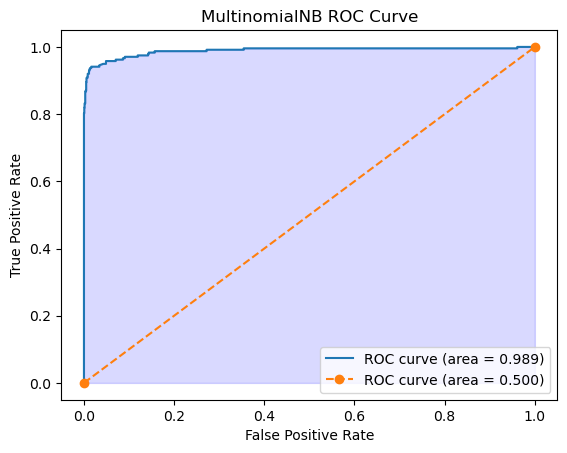

In [13]:
# Plot the ROC Curve
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.3f})')
plt.plot([0, 1], [0, 1], 'o--', label='ROC curve (area = 0.500)') 
plt.fill_between(fpr, tpr, color="blue", alpha=0.15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MultinomialNB ROC Curve')
plt.legend(loc="lower right")
plt.show()

We can see that over 98 percent is under the ROC curve. The other metrics are also looking good. So the Naive Bayes classifier does a good job. Let's save the bits we will need for our web application and store the metrics in a dictionary:

In [14]:
# Save a pickle files

import pickle
    
with open('vectorizer_nb.pkl', 'wb') as file:
    pickle.dump(vectorizer_nb, file, pickle.HIGHEST_PROTOCOL)
    
with open('mnb.pkl', 'wb') as file:
    pickle.dump(mnb, file, pickle.HIGHEST_PROTOCOL)

In [15]:
# Save metrics in dictionary

dic = {
    'Naive Bayes': {},
    'Neural Network': {}
}

dic['Naive Bayes']['Accuracy'] = accuracy
dic['Naive Bayes']['Precision'] = precision
dic['Naive Bayes']['Recall'] = recall
dic['Naive Bayes']['F1'] = f1
dic['Naive Bayes']['AUC'] = roc_auc

### 3. Neural Network Classifier

In this section, we will use the Keras API to create a NN classifier. Although less interpretable, a neural network is able to learn complex pattern between the input and output. 

Let's import the necessary libraries:

In [16]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer

Let's process the input data in a way acceptable to the Keras:

In [17]:
# Vectorize the input X data
vectorizer_nn = CountVectorizer()
vectorizer_nn.fit(X_train)
X_train_vec = vectorizer_nn.transform(X_train)
X_test_vec = vectorizer_nn.transform(X_test)

# Transform to a sparse matrix
X_train_nn = X_train_vec.toarray()
X_test_nn = X_test_vec.toarray()

# Categorize the target data
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

We will create a neural network achitecture and train the model:

In [18]:
model = Sequential(
    [
        Dense(16, input_dim=X_train_nn.shape[1]),
        Activation('relu'),
        Dense(2),
        Activation('softmax')
    ]
)

# Show model achitecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                98880     
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 98,914
Trainable params: 98,914
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fit the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

# Train the model
history = model.fit(
    X_train_nn, y_train_nn, epochs=50, batch_size=32, 
    validation_split=0.2, callbacks=[earlystop]
)

Epoch 1/50
98/98 [==============================] - 2s 8ms/step - loss: 0.4673 - accuracy: 0.9170 - val_loss: 0.2602 - val_accuracy: 0.9731
Epoch 2/50
98/98 [==============================] - 0s 5ms/step - loss: 0.1596 - accuracy: 0.9779 - val_loss: 0.1176 - val_accuracy: 0.9821
Epoch 3/50
98/98 [==============================] - 1s 6ms/step - loss: 0.0700 - accuracy: 0.9885 - val_loss: 0.0840 - val_accuracy: 0.9833
Epoch 4/50
98/98 [==============================] - 1s 7ms/step - loss: 0.0399 - accuracy: 0.9936 - val_loss: 0.0731 - val_accuracy: 0.9833
Epoch 5/50
98/98 [==============================] - 0s 5ms/step - loss: 0.0255 - accuracy: 0.9958 - val_loss: 0.0688 - val_accuracy: 0.9846
Epoch 6/50
98/98 [==============================] - 0s 5ms/step - loss: 0.0175 - accuracy: 0.9971 - val_loss: 0.0676 - val_accuracy: 0.9846
Epoch 7/50
98/98 [==============================] - 0s 5ms/step - loss: 0.0127 - accuracy: 0.9984 - val_loss: 0.0683 - val_accuracy: 0.9833
Epoch 8/50
98/98 [==

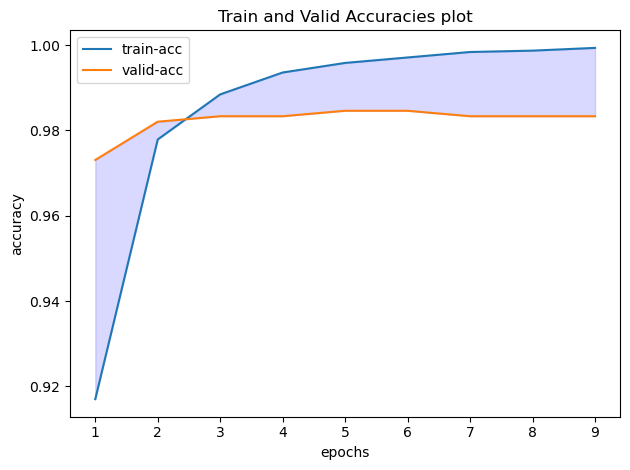

In [20]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
x_range = range(1, len(history.history['accuracy']) + 1)

plt.plot(x_range, train_acc, label='train-acc')
plt.plot(x_range, valid_acc, label='valid-acc')
plt.fill_between(x_range, train_acc, valid_acc, color="blue", alpha=0.15)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Train and Valid Accuracies plot")
plt.legend()
plt.tight_layout()
plt.show()

We can see that earlystopping made the model not to overfit the train set. Training was stopped before this could happen. Let save the bit that we will need for our web app before making predictions and estimating the performance:

In [21]:
# Save vectorize and NN model
with open('vectorizer_nn.pkl', 'wb') as file:
    pickle.dump(vectorizer_nn, file, pickle.HIGHEST_PROTOCOL)
    
model.save('nn_classifier.h5')

In [22]:
# Make predictions with NN classifier
y_pred_proba_nn = model.predict(X_test_nn)
y_pred_nn = np.argmax(y_pred_proba_nn, axis=1)

53/53 [==============================] - 0s 4ms/step


In [23]:
# Calculate metrics

accuracy = accuracy_score(np.argmax(y_test_nn, axis=1), y_pred_nn)
precision = precision_score(np.argmax(y_test_nn, axis=1), y_pred_nn)
recall = recall_score(np.argmax(y_test_nn, axis=1), y_pred_nn)
f1 = f1_score(np.argmax(y_test_nn, axis=1), y_pred_nn)
fpr, tpr, thresholds = roc_curve(y_test_nn[:, 1], y_pred_proba_nn[:, 1])
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"AUC: {roc_auc:.3f}")

Accuracy: 0.983
Precision: 0.991
Recall: 0.887
F1-score: 0.936
AUC: 0.989


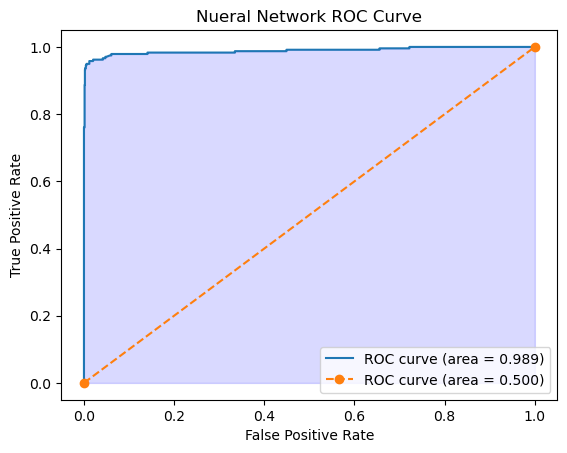

In [24]:
# plot the ROC curve

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.3f})')
plt.plot([0, 1], [0, 1], 'o--', label='ROC curve (area = 0.500)') 
plt.fill_between(fpr, tpr, color="blue", alpha=0.15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Nueral Network ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Save metrics in dictionary

dic['Neural Network']['Accuracy'] = accuracy
dic['Neural Network']['Precision'] = precision
dic['Neural Network']['Recall'] = recall
dic['Neural Network']['F1'] = f1
dic['Neural Network']['AUC'] = roc_auc

In [26]:
# Show the metrics of NaiveBayes and Neural network

pd.DataFrame(dic)

,Naive Bayes,Neural Network
Accuracy,0.962321,0.982656
Precision,1.000000,0.990610
Recall,0.735294,0.886555
F1,0.847458,0.935698
AUC,0.988514,0.988945


We can see that overall, the Neural Network classifer performs better than the Naive Bayes classifier

### 4. Build the web app

We shall buld the web app in the `web_app.py` module. To run the web app:
- Ensure that you have saved all the relevant `pickle` and `.h5` files
- Ensure that these files are in the same directory as the `web_app.py`
- Go to this directory in your command line terminal and run: `streamlit run web_app.py` to start the web app

In [ ]:
!streamlit run web_app.py